**Цель на проект:** провести анализ данных анкет посетителей фитнес-центра и подготовить план действий по удержанию клиентов.

**Задачи:**

- научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
- сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
- проанализировать основные признаки, наиболее сильно влияющие на отток;
- сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:

**Вводные данные** - таблица, которая содержит данные на месяц до оттока и факт оттока на определённый месяц. Набор данных включает данные клиента за предыдущий до проверки факта оттока месяц, а также информацию на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента.


In [1]:
# импорт необходимых библиотек

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, silhouette_score
from sklearn.ensemble import RandomForestClassifier
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from plotly import graph_objects as go

* [Обзор и предобработка данных](#1-bullet)
* [Исследовательский анализ данных (EDA)](#2-bullet)
* [Модель прогнозирования оттока клиентов](#3-bullet)
* [Кластеризация клиентов](#4-bullet)
* [Выводы](#5-bullet)

## Обзор и предобработка данных <a class="anchor" id="1-bullet"></a>

In [2]:
# прочитаем данные в переменную df
df = pd.read_csv('/Users/grigorij/Desktop/Портфолио/Машинное обучение/gym_churn.csv')
df

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,1,1,1,0,1,12,0,33,2.406023,12.0,8,2.284497,2.349070,0
3996,0,1,0,0,1,1,1,29,68.883764,1.0,1,1.277168,0.292859,1
3997,1,1,1,1,1,12,0,28,78.250542,11.0,2,2.786146,2.831439,0
3998,0,1,1,1,1,6,0,32,61.912657,5.0,3,1.630108,1.596237,0


Исправим названия столбцов - приведем их к нижнему регистру

In [3]:
df.columns = df.columns.str.lower()
df.columns

Index(['gender', 'near_location', 'partner', 'promo_friends', 'phone',
       'contract_period', 'group_visits', 'age',
       'avg_additional_charges_total', 'month_to_end_contract', 'lifetime',
       'avg_class_frequency_total', 'avg_class_frequency_current_month',
       'churn'],
      dtype='object')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   near_location                      4000 non-null   int64  
 2   partner                            4000 non-null   int64  
 3   promo_friends                      4000 non-null   int64  
 4   phone                              4000 non-null   int64  
 5   contract_period                    4000 non-null   int64  
 6   group_visits                       4000 non-null   int64  
 7   age                                4000 non-null   int64  
 8   avg_additional_charges_total       4000 non-null   float64
 9   month_to_end_contract              4000 non-null   float64
 10  lifetime                           4000 non-null   int64  
 11  avg_class_frequency_total          4000 non-null   float

Пропусков в данных не обнаружено.

In [5]:
print('Количество дублей в строках: {}\n'.format(df.duplicated().sum()))

Количество дублей в строках: 0



In [6]:
#переведем тип данных в столбце month_to_end_contract в целочисленный
df.month_to_end_contract = df.month_to_end_contract.astype(np.int64)

Промежуточный вывод: в датасете 4000 строк, нет пропусков и дубликатов. Превели названия столбцов к нижнему регистру и числовые значения в столбце с месяцами к целочисленному типу для удобства при дальнейшей работе.

## Исследовательский анализ данных (EDA) <a class="anchor" id="2-bullet"></a>

Посмотрим на датасет, есть ли в нем отсутствующие признаки, изучим средние значения и стандартные отклонения.

In [7]:
df.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


- Судя по данным, большая часть клиентов живут недалеко от фитнес-центров: среднее значение Near_Location близко к единице, а отклонение - небольшое. 
- Клиентов, пришедщих с партнерских коллабораций больше, чем привлеченных по акции "Приведи друга".
- 10% клиентов не указали свой номер телефона
- Средний возраст клиента составляет 29 лет
- Меньше половины посещают групповые занятия
- Разброс в сроке действия абонемента и срока до его окончания - достаточно большой.
- Есть клиенты, которые еще ни разу не посетили занятия и те, кто занимается уже более 2 лет.
- В среднем посещают клуб 1-2 раза в неделю
- Максимальная выручка с допуслуг в центрах более 550, в среднем - 147.
- Отток пользователей составляет 0.26, однако разброс значений не такой маленький - 0.44.

Посмотрим на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался

In [8]:
df.groupby('churn').agg('mean').T

churn,0,1
gender,0.510037,0.510839
near_location,0.873086,0.768143
partner,0.534195,0.355325
promo_friends,0.353522,0.183789
phone,0.903709,0.902922
contract_period,5.747193,1.728558
group_visits,0.464103,0.268615
age,29.976523,26.989632
avg_additional_charges_total,158.445715,115.082899
month_to_end_contract,5.283089,1.662582


Посетители в оттоке: пол не влияет значения, это клиенты, которые чаще живут не в непосредственной близости к клубу, пришедшие не по партнерской скидочной программе, которые реже посещают групповые занятия, в среднем занимаются около месяца-двух.


Построим столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток);

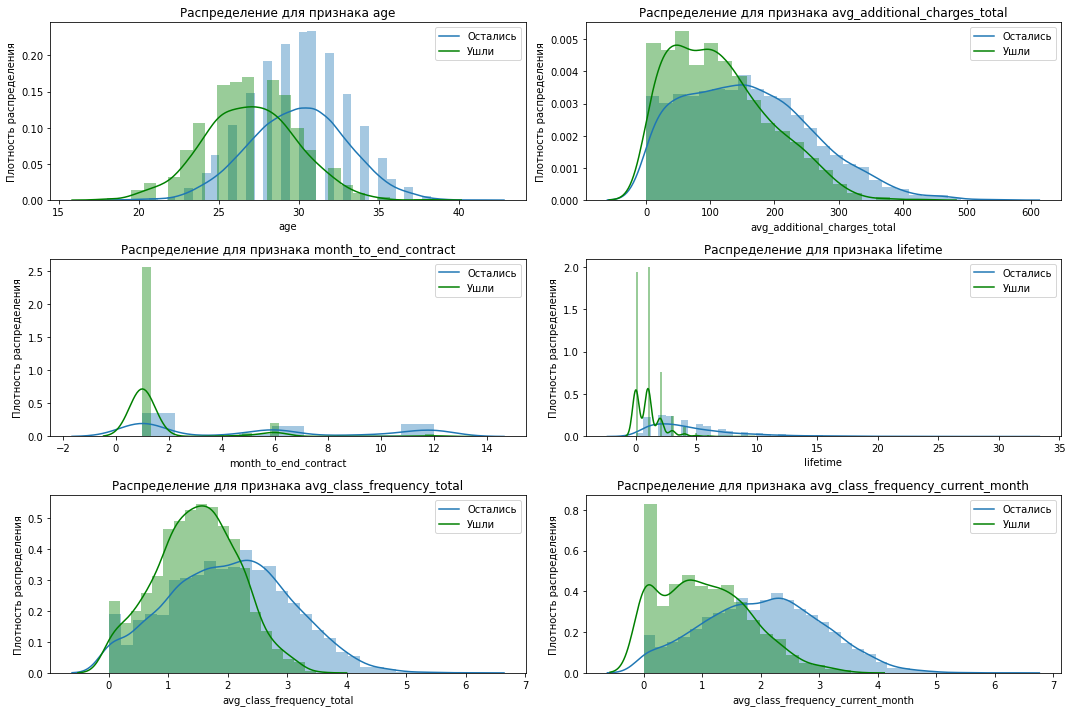

In [9]:
num_feat = df.drop(columns =(['gender', 'near_location', 
                              'partner','promo_friends', 'phone',
                              'group_visits', 'contract_period', 'churn'])).columns


clients_no_churn = df.query('churn <= 0')
clients_churn = df.query('churn != 0')

fig = plt.figure(figsize=(15,10))

for i in [0,1,2,3,4,5]:
    
    fig.add_subplot(3, 2, i+1)
    sns.distplot(clients_no_churn[num_feat[i]])
    sns.distplot(clients_churn[num_feat[i]], color = 'g')
    plt.legend(labels = ('Остались', 'Ушли'))
    plt.title('Распределение для признака ' + num_feat[i])
    plt.ylabel("Плотность распределения")
    plt.tight_layout()
    
plt.show()    

- Молодые уходят чаще, чем взрослые
- Ушедшие клиенты тратят меньше
- Клиенты в оттоке, в основном, покупают абономент на один месяц
- Уходят только новички, если клиент проходил в зал больше 5 ммесяцев, то его уход почти равен нулю
- Клиенты в оттоке чаще всего посещают зал от 1 до 2 раз в неделю
- Если клиент ни разу не посетил зал за месяц, то вероятнее всего он больше не вернется, если же посетил зал больше 4-х раз, то вероятнее всего он станет постоянным клиентом

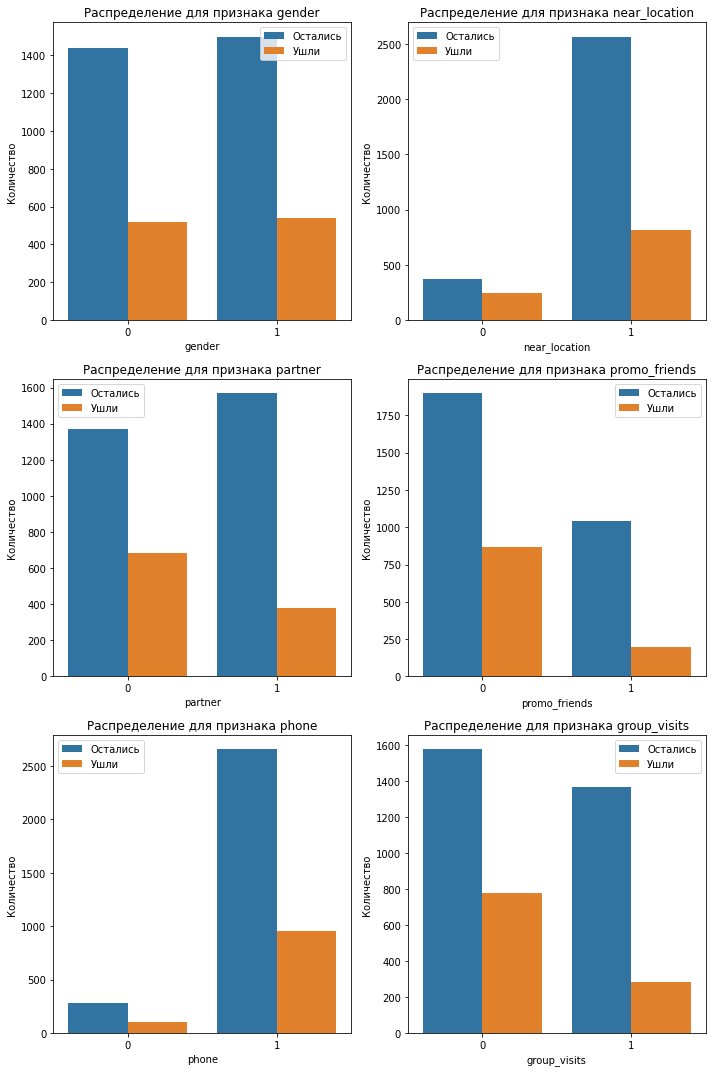

In [10]:
#построим countplot-графики для бинарных признаков

column = ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'group_visits']
fig = plt.figure(figsize=(10,15))

for i in [0,1,2,3,4,5]:
    
    fig.add_subplot(3, 2, i+1)
    sns.countplot(x = df[column[i]], hue='churn', data=df)
    plt.legend(labels = ('Остались', 'Ушли'))
    plt.title('Распределение для признака ' + column[i])
    plt.ylabel("Количество")
    plt.tight_layout()
    
plt.show()    

- факт оттока не зависит от пола посетителя
- не посещавшие групповые занятия, попадают в отток чаще
- не имеющие друзей/коллег в клубе прекращают ходить чаще
- большая часть людей из отток живут рядом с клубом
- факт непредоставления номера телефона не влияет на отток

Построим матрицу корреляций:

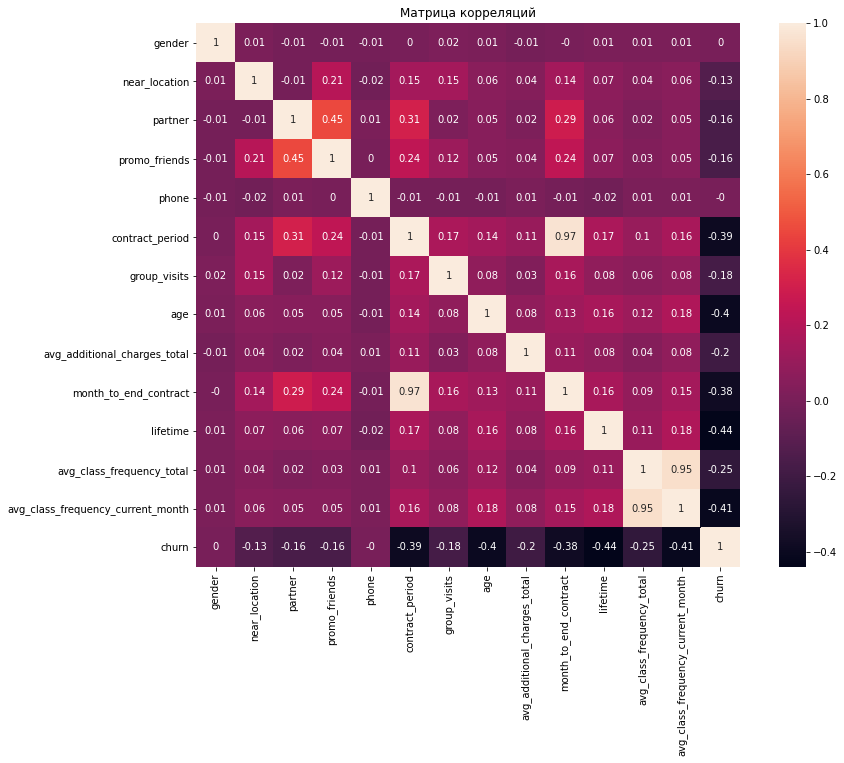

In [11]:
plt.figure(figsize=(14,10))
sns.heatmap(data = df.corr().round(2), annot=True, square=True)
plt.title('Матрица корреляций')
plt.show()

- Очевидной зависимости оттока от конкретных признаков нет
- Есть 4 мультиколлинеарных признака - contract_period и month_to_end_contact, avg_class_frequency_current_month и avg_class_frequency_total

## Модель прогнозирования оттока клиентов <a class="anchor" id="3-bullet"></a>

Построим модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце.

- Разобъем данные на обучающую и валидационную выборки функцией train_test_split()
- Обучим модель на train-выборке логистической регрессией и случайным лесом
- Оценим метрики accuracy, precision и recall для обеих моделей на валидационной выборке. Сравним по ним модели. Какая модель показала себя лучше на основании метрик?

In [12]:
#зададим функцию для вывода метрик классификации

def print_all_metrics(y_true, y_pred, y_proba, title='Метрики классификации'):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))

In [13]:
# разделим наши данные на признаки (матрица X) и целевую переменную (y)
X = df.drop(['churn'], axis = 1)
y = df['churn']

# разделяем модель на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0
)

# обучим StandartScaler на обучающей выборке
scaler = StandardScaler()
scaler.fit(X_train)

# Преобразуем обучающий и валидационные наборы данных
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

In [14]:
# Преобразуем обучающий и валидационные наборы данных
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

# зададим алгоритм для модели логистической регрессии
lr_model = LogisticRegression(random_state=0)
# обучим модель
lr_model.fit(X_train_st, y_train)
# воспользуемся уже обученной моделью, чтобы сделать прогнозы
lr_predictions = lr_model.predict(X_test_st)
lr_probabilities = lr_model.predict_proba(X_test_st)[:, 1]
# выведем все метрики
print_all_metrics(
    y_test,
    lr_predictions,
    lr_probabilities,
    title='Метрики для модели логистической регрессии:',
)


Метрики для модели логистической регрессии:
	Accuracy: 0.92
	Precision: 0.85
	Recall: 0.83


In [15]:
# зададим алгоритм для новой модели на основе алгоритма случайного леса
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0) 
# обучим модель случайного леса
rf_model.fit(X_train_st, y_train)
# воспользуемся уже обученной моделью, чтобы сделать прогнозы
rf_predictions = rf_model.predict(X_test_st) 
rf_probabilities = rf_model.predict_proba(X_test_st)[:, 1]
# выведем все метрики
print_all_metrics(
    y_test,
    rf_predictions,
    rf_probabilities, 
    title='Метрики для модели случайного леса:'
)

Метрики для модели случайного леса:
	Accuracy: 0.92
	Precision: 0.84
	Recall: 0.81


Доля правильных прогнозов и полнота чуть выше в модели логистической регрессии. Таким образом, модель логистической регрессии показала себя лучше.

## Кластеризация клиентов <a class="anchor" id="4-bullet"></a>


Проведем кластеризацию пользователей без столбца целевого значения

- Стандартизируем данные
- Построим матрицу расстояний функцией linkage() на стандартизированной матрице признаков и нарисуем дендограмму. Предположим, какое количество кластеров можем выделить.
- Обучим модель кластеризации на основе алгоритма K-Means и спрогнозируем кластеры клиентов. (берём n=5 кластеров)

In [16]:
# обязательная стандартизация данных перед работой с алгоритмами
sc = StandardScaler()
X_sc = sc.fit_transform(X)

linked = linkage(X_sc, method = 'ward')

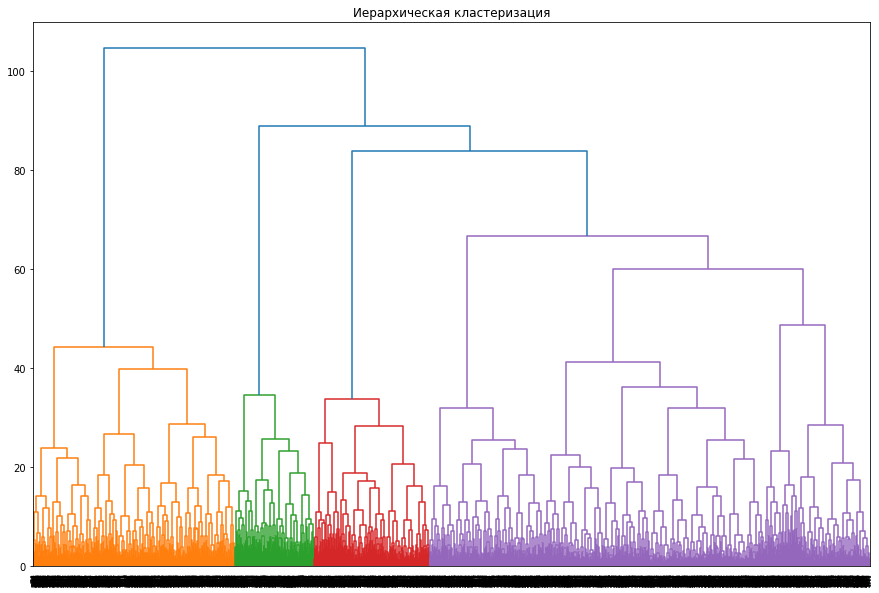

In [17]:
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Иерархическая кластеризация')
plt.show()

In [18]:
# задаём модель k_means с числом кластеров 3 и фиксируем значение random_state
km = KMeans(n_clusters=5, random_state=0)
# прогнозируем кластеры для наблюдений (алгоритм присваивает им номера от 0 до 2)
labels = km.fit_predict(X_sc)

# сохраняем метки кластера в поле нашего датасета
df['cluster_km'] = labels

In [19]:
df.groupby('cluster_km').agg('mean')

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
cluster_km,,,,,,,,,,,,,,
0,0.502970,0.959406,0.783168,0.574257,1.000000,10.889109,0.542574,29.982178,160.761016,9.954455,4.736634,1.982055,1.974789,0.027723
1,0.522078,0.862338,0.470130,0.306494,0.000000,4.787013,0.425974,29.301299,143.957664,4.475325,3.924675,1.847220,1.716369,0.267532
2,0.495050,0.000000,0.463366,0.079208,1.000000,2.352475,0.215842,28.477228,135.457501,2.198020,2.809901,1.660461,1.477324,0.443564
3,0.485737,1.000000,0.350238,0.240095,1.000000,1.948494,0.341521,28.167987,131.622204,1.856577,2.440571,1.247634,1.012983,0.514263
4,0.559666,0.976134,0.356802,0.230310,0.998807,2.669451,0.473747,30.125298,161.657905,2.459427,4.898568,2.852002,2.850161,0.068019


In [20]:
df['cluster_km'].value_counts()

3    1262
0    1010
4     838
2     505
1     385
Name: cluster_km, dtype: int64

Кластер 0:
- Отток - 3% - самый низкий
- Живут или работают недалеко от фитнес-центра
- Преобладают сотрудники компаний-партнеров - 78%
- Заключают договора на длительный срок - больше 10 мес
- Чаще всех посещают групповые занятия - 54%
- Больше людей, пришедших по акции "приведи друга"

Кластер 1:
- Отток - 26%
- Живут или работают недалеко от фитнес-центра
- Нет мобильного номера
- В среднем 4.5 месяцев контракты

Кластер 2:

- Отток - 44%
- Похожи на кластер 0, но живут или работают в другом районе
- 7% пришли по промо акции
- Реже всех посещают групповые занятия

Кластер 3:

- Отток - 52% - самый высокий
- Живут или работают недалеко от фитнес-центра
- В основном обладатели недолгосрочных абонементов на 1-3 месяца
- Наименьшее кол-во посещений за всё время и в последний месяц

Кластер 4:

- Отток 7%
- Живут или работают недалеко от фитнес-центра
- Чаще всех посещают клуб - 2.81 раз в неделю
- Договора НЕ на длительный срок - в среднем 2.8 месяцев


Построим распределения признаков для кластеров и посмотрим, можно ли что-то заметить по ним.

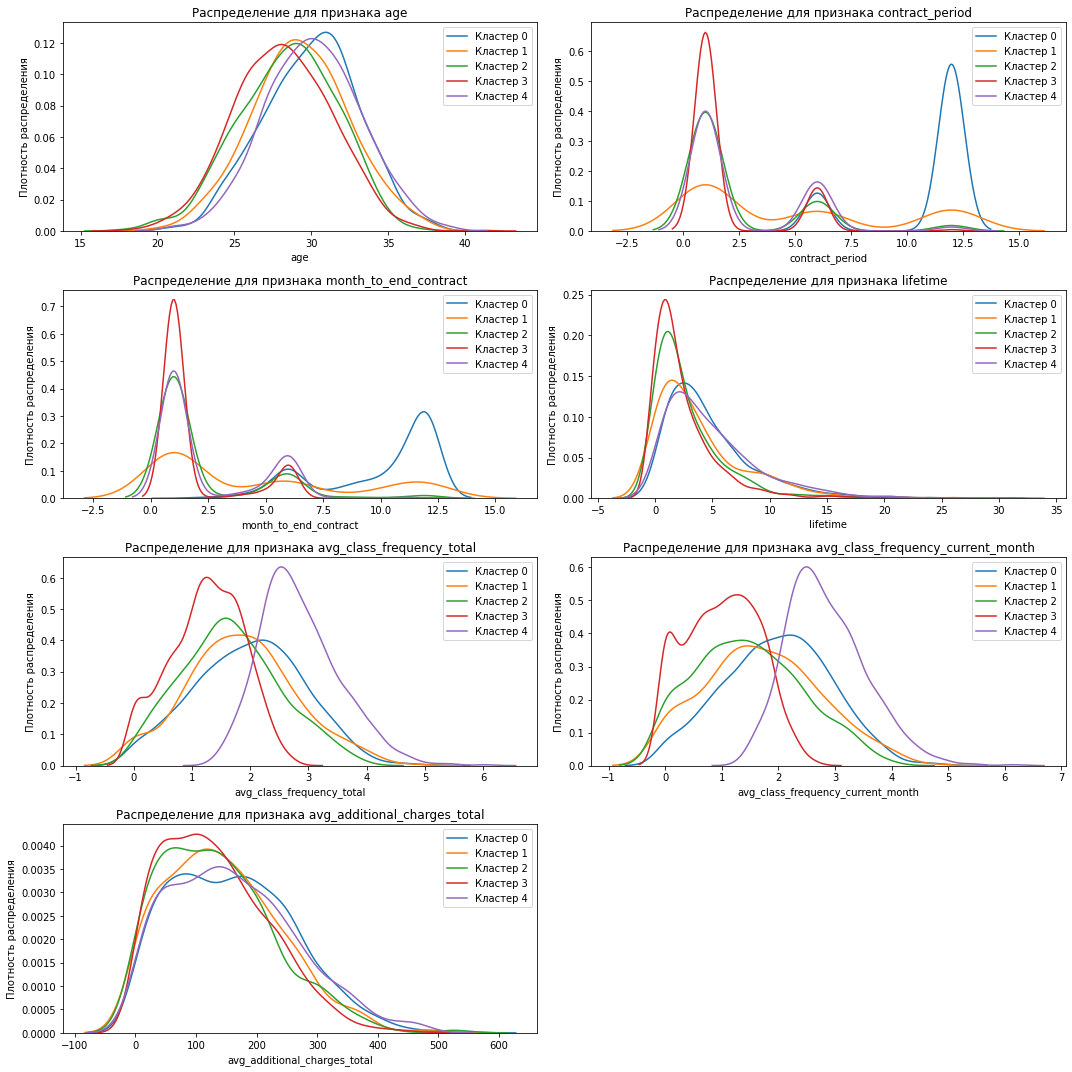

In [21]:
#построим kdeplot-графики для небинарных признаков

column = ['age', 'contract_period', 'month_to_end_contract', 'lifetime', 'avg_class_frequency_total', 'avg_class_frequency_current_month', 'avg_additional_charges_total']
fig = plt.figure(figsize=(15,15))

for i in [0,1,2,3,4,5,6]:
    
    fig.add_subplot(4, 2, i+1)
    sns.kdeplot(df.query('cluster_km==0')[column[i]], label = 'Кластер 0')
    sns.kdeplot(df.query('cluster_km==1')[column[i]], label = 'Кластер 1')
    sns.kdeplot(df.query('cluster_km==2')[column[i]], label = 'Кластер 2')
    sns.kdeplot(df.query('cluster_km==3')[column[i]], label = 'Кластер 3')
    sns.kdeplot(df.query('cluster_km==4')[column[i]], label = 'Кластер 4')
    plt.title('Распределение для признака ' + column[i])
    plt.ylabel("Плотность распределения")
    plt.tight_layout()
    plt.legend()
    
plt.show()  

Из графиков признаков можно выделить такие особенности:

- `age` - возраст клиентов примерно в одлном промежутке. Можно заметить, что в 3-ем кластере клиенты чуть старше остальных.
- `contract_period` - основной срок абонементов - 1,6,12 месяцев. 0 кластер состоит в основном из 12месячных абонементов, а в кластерах 3 и 4 больше преобладают месячные абонементы.
- `month_to_end_contract` - здесь можно опять выделить кластер 0 - у них осталось 6 и больше месяцев от абонемента.
- `lifetime` - в 3 кластере ходили 2 месяца и меньше, а в 0 - те, кто больше 2 месяцев.
- `avg_class_frequency_total` - 3 кластер - те кто ходит в среднем 1 раз, 0 кластер - те кто ходит 2-3раза, а в 4 входят те, кто ходят 3-4 раза
- `avg_class_frequency_current_month` - схоже с `avg_class_frequency_total`
- `avg_additional_charges_total` - чаще тратят клиенты 3 и 2 кластеров (но здесь же больше отток), а больше по сумме тратят в 0 кластере.

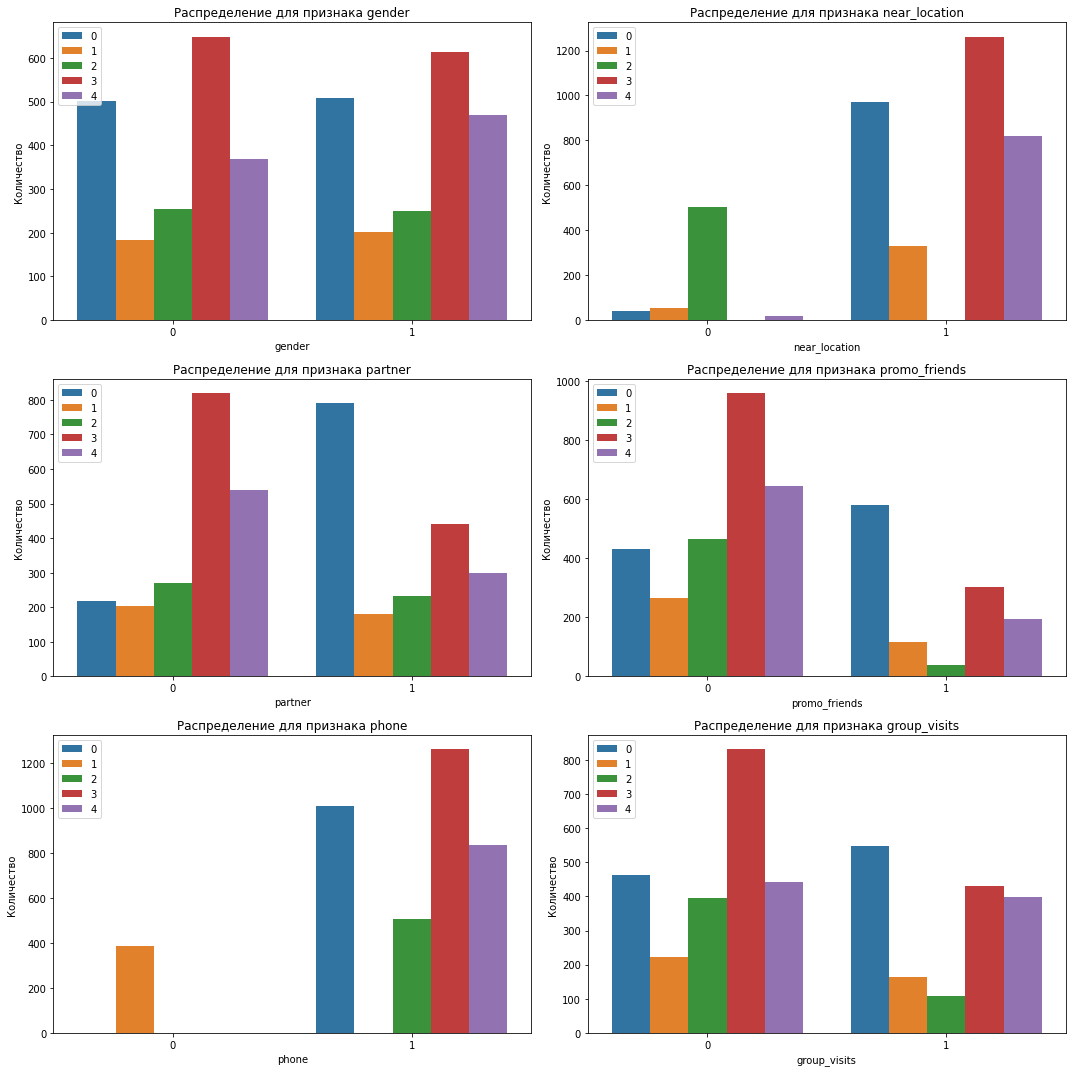

In [22]:
#построим countplot-графики для бинарных признаков

column = ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'group_visits']
fig = plt.figure(figsize=(15,15))

for i in [0,1,2,3,4,5]:
    
    fig.add_subplot(3, 2, i+1)
    sns.countplot(x = df[column[i]], hue='cluster_km', data=df)
    plt.title('Распределение для признака ' + column[i])
    plt.ylabel("Количество")
    plt.tight_layout()
    plt.legend(loc='upper left')
    
plt.show()  

Из графиков бинарных признаков можно выделить следующие особенности кластеров:

- `gender` - пол распределен примерно одинаково по кластерам
- `near_location` - заметно, что во 2 кластере люди живут не рядом с клубом
- `partner` - в 0 кластере больше всего клиентов, пришедших по партнерской программе, а 3-ий кластер входит больше всего людей, пришедших не из партнерской программы.
- `promo_friends` - в 0 и 3 кластере чаще приходят от друзей, 1 и 4 - чаще не от друзей.
- `phone` - в кластере 1 больше тех, кто не оставил номер телефона
- `group_visits` - кластер 0 чаще ходит на групповые занятия, а 3-ий - реже всего.

## Выводы <a class="anchor" id="5-bullet"></a>

В ходе проекта мы предобработали и исследовали исходные данные. После обзора информации датасета, можно сказать:

Судя по данным, большая часть клиентов живут недалеко от фитнес-центров. Клиентов, пришедщих с партнерских коллабораций больше, чем привлеченных по акции "Приведи друга". 10% клиентов не указали свой номер телефона. Средний возраст клиента составляет 29 лет. Меньше половины посещают групповые занятия. Есть клиенты, которые еще ни разу не посетили занятия и те, кто занимается уже более 2 лет.
В среднем посещают клуб 1-2 раза в неделю. Максимальная выручка с допуслуг в центрах более 550, в среднем - 147.
Средний отток пользователей составляет 0.26, однако разброс значений не такой маленький - 0.44.

**Общие признаки клиентов, попавших в отток:**

- Молодые уходят чаще, чем взрослые
- Ушедшие клиенты тратят меньше
- Клиенты в оттоке, в основном, покупают абономент на один месяц
- Уходят только новички, если клиент проходил в зал больше 5 ммесяцев, то его уход почти равен нулю
- Клиенты в оттоке чаще всего посещают зал от 1 до 2 раз в неделю
- Если клиент ни разу не посетил зал за месяц, то вероятнее всего он больше не вернется, если же посетил зал больше 4-х раз, то вероятнее всего он станет постоянным клиентом
- Факт оттока не зависит от пола посетителя
- Не посещавшие групповые занятия, попадают в отток чаще
- Не имеющие друзей/коллег в клубе прекращают ходить чаще
- Большая часть людей из оттока живут рядом с клубом
- Факт непредоставления номера телефона не влияет на отток

Мы построили модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце. Модель была обучена на train-выборке двумя способами: логистической регрессией и случайным лесом. Доля правильных прогнозов и полнота оказалась чуть выше в модели логистической регрессии. Таким образом, модель логистической регрессии показала себя лучше.

Затем мы кластеризовали клиентов на 5 групп на основании алгоритма K-Means, изучили средние значения признаков для кластеров и построили распределения по ним, посчитали долю оттока. 

Таким образом, мы выделили следующие **целевые группы клиентов** со следующими характерными чертами:

**Кластер 0:**
- Отток - 3% - самый низкий
- Живут или работают недалеко от фитнес-центра
- Преобладают сотрудники компаний-партнеров - 78%
- Заключают договора на длительный срок - больше 10 мес
- Чаще всех посещают групповые занятия - 54%
- Больше людей, пришедших по акции "приведи друга"

**Кластер 1:**
- Отток - 26%
- Живут или работают недалеко от фитнес-центра
- Нет мобильного номера
- В среднем 4.5 месяцев контракты

**Кластер 2:**

- Отток - 44%
- Похожи на кластер 0, но живут или работают в другом районе
- Всего 7% пришли по промо-акции
- Реже всех посещают групповые занятия

**Кластер 3:**

- Отток - 52% - самый высокий
- Живут или работают недалеко от фитнес-центра
- В основном обладатели недолгосрочных абонементов на 1-3 месяца
- Наименьшее кол-во посещений за всё время и в последний месяц
- Большая часть кластера не ходит на групповые занятия
- Чаще других приходят НЕ по партнерской программе

**Кластер 4:**

- Отток 7%
- Живут или работают недалеко от фитнес-центра
- Чаще всех посещают клуб - 2.81 раз в неделю
- Договора НЕ на длительный срок - в среднем 2.8 месяцев
- Чуть меньше половины ходят на групповые занятия

**Анализ распределений по признакам показал, что на отток посетителей больше влияет:**

- срок абонемента (клиенты с месячным абонементом чаще попадают в отток, чем с годовым)
- частота посещений и посещение групповых занятий (меньше всего оттока - в кластере с регулярным посещением зала и групповых занятий)
- участие клиента в партнерской программе/акции "приведи друга" (наличие друзей и знакомых в клубе может служить дополнительной мотивацией)
- удаленность от фитнес-центра (кластер с 44% оттока - единственный, в котором клиенты живут на удалении от фитнес-центра)

Также можно отметить, что в кластерах с большим оттоком клиенты склонны чаще совершать дополнительные покупки на небольшие суммы, в то время как более устойчивые кластеры тратят больше, но реже. Возможно нужно проанализировать структуру продаж по кластерам, чтоб понять, что их больше привлекает.

**Какие стретегии для маркетинга можно предложить:**

- Работа над увеличением среднего срока абонементов (например, пересмотреть линейку абонементов в сторону увеличения их срока, но с более выгодной ценой в пересчете на месяц)
- Увеличение частоты посещений (возможно, тут людям не хватает мотивации: можно провести глубинные интервью и выяснить, что заставляет людей посещать клуб чаще. Есть вероятность, что введение дополнительных сервисов повысит чатоту посещений - например, собственное приложение с тренировками/улучшение качества обслуживания и тд)
- Работать над развитием коммьюнити (люди с друзьями в клубе задерживаются дольше - поэтому можно заводить знакомства внутри клуба - через дополнительные воркшопы/вечеринки/встречи с тренерами и тд)
- Работа с клиентам, живущих на удалении от фитнес-центра (в этом случае объективную причину - долгую дорогу до клуба можно нивелировать дополнительной ценностью. Например, скидками на СПА, выгодной ценой на услуги тренеров, расширенным абонементом по сравнению с конкурентами на районе клиента.)  


